In [1]:
from mixer.models.modeling import MlpMixer, CONFIGS
import numpy as np
from cka_heatmap import compute_heatmap, display_heatmap, cka_linear
from data_loaders import get_imagenet_test_loader, get_cifar10_val_loader

In [2]:
mixer = MlpMixer(CONFIGS['Mixer-B_32'])
mixer.load_from(np.load("mixer/checkpoint/Mixer-SAM-B_32.npz"))

In [ ]:
mixer = MlpMixer(CONFIGS['Mixer-B_16'])
mixer.load_from(np.load("mixer/checkpoint/Mixer-B_16.npz"))

In [ ]:
mixer = MlpMixer(CONFIGS['Mixer-B_16'])
mixer.load_from(np.load("mixer/checkpoint/Mixer-SAM-B_16.npz"))

In [ ]:
mixer = MlpMixer(CONFIGS['Mixer-L_16'])
mixer.load_from(np.load("mixer/checkpoint/Mixer-L_16.npz"))

In [3]:
def get_activation_hook(act, idx):
    def hook(model, input, output):
        act[idx] = output.detach().numpy()
    return hook


def add_hooks(mixer):
    act = [None for _ in mixer.layer]
    for i, layer in enumerate(mixer.layer):
        layer.register_forward_hook(get_activation_hook(act, i))
    return act


def get_activations(mixer, loader):
    act = add_hooks(mixer)
    _ = mixer(next(iter(loader))[0])
    return act

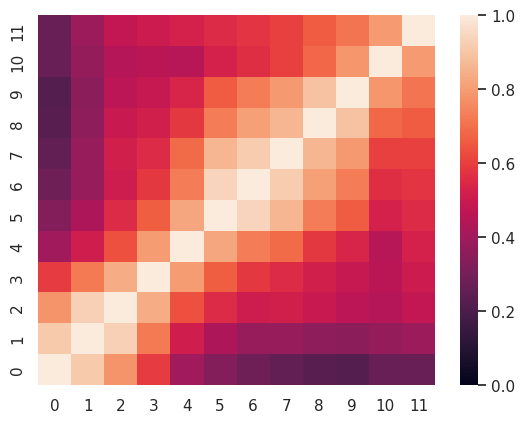

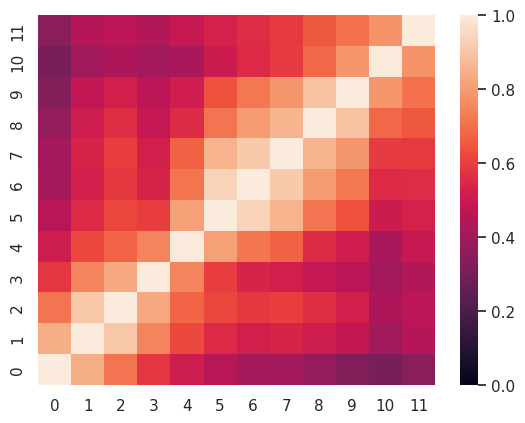

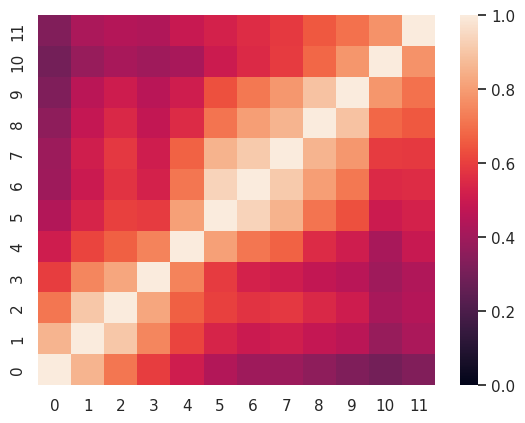

In [4]:
for batch_size in (1, 16, 64):
    loader = get_imagenet_test_loader(batch_size)
    act = get_activations(mixer, loader)
    heatmap = compute_heatmap(act, act)
    display_heatmap(heatmap)